In [1]:
from jax import config
config.update('jax_enable_x64', True)

import jax
import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from uncprop.core.inverse_problem import Posterior
from uncprop.models.vsem.inverse_problem import generate_vsem_inv_prob_rep

from uncprop.core.surrogate import construct_design
from uncprop.utils.gpjax_models import construct_gp, train_gp_hyperpars
from uncprop.utils.plot import set_plot_theme
from uncprop.utils.grid import Grid

from uncprop.models.vsem.surrogate import VSEMSurrogate

colors = set_plot_theme()
key = jr.key(53212)

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# settings
n_months = 24
n_days_per_month = 30
par_names = ['kext', 'av']
observed_variable = 'lai'
noise_sd = 0.1
noise_cov = (noise_sd ** 2) * jnp.identity(n_months)
noise_cov_tril = jnp.sqrt(noise_cov)

# construct inverse problem
posterior = generate_vsem_inv_prob_rep(key=key,
                                       par_names=par_names,
                                       n_windows=n_months,
                                       n_days_per_window=n_days_per_month,
                                       observed_variable=observed_variable,
                                       noise_cov_tril=noise_cov_tril)

In [3]:
grid = Grid(low=posterior.support[0],
            high=posterior.support[1],
            n_points_per_dim=[50, 50],
            dim_names=posterior.prior.par_names)

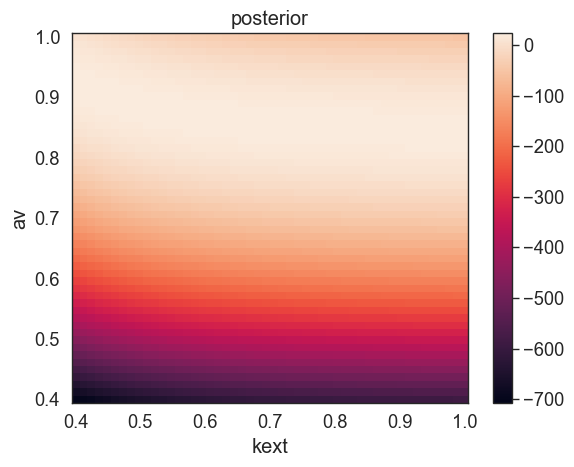

In [4]:
fig, ax = grid.plot(f=posterior._get_log_density_function(),
                    title='posterior')

In [5]:
from uncprop.utils.grid import DensityComparisonGrid

density_grid = DensityComparisonGrid(grid=grid, distributions={'exact': posterior})

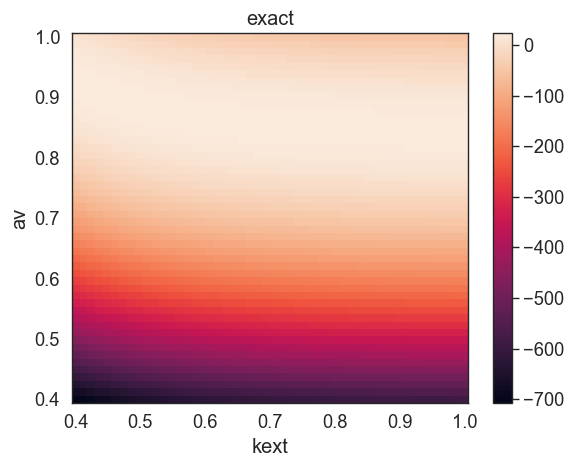

In [12]:
fig, ax = density_grid.plot('exact', normalized=True, log_scale=True)

In [ ]:
# sampling posterior
key, key_mcmc = jr.split(key, 2)

samp = posterior.sample(key, n=3000, num_warmup_steps=500) # returns HMCState with samp.position (n, 1, 2)

In [ ]:
import matplotlib.pyplot as plt

plt.hist(samples[:,0])
plt.show()

### Fit Surrogate

In [ ]:
key, key_design = jr.split(key, 2)

# sample design points
design = construct_design(key=key_design,
                          design_method='lhc', 
                          n_design=15, 
                          prior=posterior.prior,
                          f=lambda x: posterior.log_density(x))

# fit log-posterior surrogate
surrogate = VSEMSurrogate(design=design, exact_posterior=posterior)
surrogate.summarize_fit()

In [ ]:
from uncprop.core.surrogate import LogDensGPSurrogate

surrogate_post = LogDensGPSurrogate(log_dens=surrogate, support=posterior.support)

In [ ]:
arr = jnp.array([1,2,3])
nm = ['a', 'b', 'c']

dict(zip(nm, arr))

In [ ]:
from datetime import date
import jax
import jax.scipy.stats as stats
import numpy as np

rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

loc, scale = 10, 20
observed = np.random.normal(loc, scale, size=1_000)

def logdensity_fn(loc, log_scale, observed=observed):
    """Univariate Normal"""
    scale = jnp.exp(log_scale)
    logjac = log_scale
    logpdf = stats.norm.logpdf(observed, loc, scale)
    return logjac + jnp.sum(logpdf)
logdensity = lambda x: logdensity_fn(**x)

In [ ]:
from uncprop.core.samplers import init_nuts_kernel, mcmc_loop

initial_position = {"loc": 1.0, "log_scale": 1.0}
init_state, kernel = init_nuts_kernel(rng_key, logdensity, initial_position, num_warmup_steps=100)

In [ ]:
key, mcmc_key = jr.split(rng_key)

states = mcmc_loop(mcmc_key, kernel, init_state, num_samples=4000)

In [ ]:
from uncprop.core.samplers import get_trace_plots

fig, ax = get_trace_plots(states.position)
display(fig)